In [1]:
import argparse
from datetime import datetime
import json
from pprint import pprint

from explorecourses import *  # pip install the explorecourses package
import pandas as pd

In [2]:
import requests
from typing import List, Tuple
import xml.etree.ElementTree as ET

### Start here if you have already saved it

In [43]:
all_years_course_data_df = pd.read_csv('all_course_data_01_13_2021.csv')

In [44]:
all_years_course_data_df[['year', 'code']].drop_duplicates().groupby('year').count()

code
year           
2010-2011  3162
2011-2012  3282
2012-2013  3279
2013-2014  3525
2014-2015  3914
2015-2016  4083
2016-2017  4334
2017-2018  4459
2018-2019  4576
2019-2020  4571
2020-2021  4757

In [45]:
all_2010s_df = all_years_course_data_df.loc[(all_years_course_data_df['year'] != '2020-2021')]
# all_2010s_df.head()

In [46]:
academic_year_df = all_2010s_df[all_2010s_df['attributes'].apply(lambda x: 'NQTR::AUT' in x or 'NQTR::WIN' in x or 'NQTR::SPR' in x)]\
    [['year', 'subject', 'code', 'title', 'attributes', 'description', 'sections', 'gers']]

academic_year_df['sections_clean'] = academic_year_df['sections']\
    .apply(lambda x: [(c['component'], c['curr_class_size'], c['term'].split()[-1]) 
                     for c in json.loads(x) 
                     if c['term'].split()[-1].lower() != 'summer'])
academic_year_df = academic_year_df.explode('sections_clean')

In [47]:
academic_year_df = academic_year_df\
    .drop('sections', 'columns')\
    .loc[academic_year_df['sections_clean'].notnull()]

In [48]:
academic_year_df['component'] = academic_year_df['sections_clean'].apply(lambda x: x[0])
academic_year_df['enrollment'] = academic_year_df['sections_clean'].apply(lambda x: x[1])
academic_year_df['term'] = academic_year_df['sections_clean'].apply(lambda x: x[2])
academic_year_df = academic_year_df.drop(['sections_clean', 'attributes'], 'columns')

In [49]:
# Filter discussions, independent studies, labs, thesis/dissertation, and recitation
academic_year_df = academic_year_df[~academic_year_df['component'].isin(
    ['DIS', 'INS', 'LBS', 'T/D', 'RES'])]

In [50]:
term_enrollment_df = academic_year_df\
    .groupby(['year', 'subject', 'code', 'title', 'description', 'term'])\
    .agg({'enrollment': 'sum'})\
    .sort_values(by='year').reset_index()

In [51]:
term_enrollment_df.loc[term_enrollment_df['code'] == '224N']

year  subject  code  \
6464   2010-2011       CS  224N   
13801  2011-2012       CS  224N   
21583  2012-2013       CS  224N   
29587  2013-2014       CS  224N   
35325  2014-2015       CS  224N   
44065  2015-2016       CS  224N   
52955  2016-2017       CS  224N   
61735  2017-2018       CS  224N   
71080  2018-2019       CS  224N   
71857  2018-2019  ARTHIST  224N   
80858  2019-2020       CS  224N   

                                                   title  \
6464          Natural Language Processing (LINGUIST 284)   
13801         Natural Language Processing (LINGUIST 284)   
21583         Natural Language Processing (LINGUIST 284)   
29587         Natural Language Processing (LINGUIST 284)   
35325         Natural Language Processing (LINGUIST 284)   
44065         Natural Language Processing (LINGUIST 284)   
52955  Natural Language Processing with Deep Learning...   
61735  Natural Language Processing with Deep Learning...   
71080  Natural Language Processing with Deep Learning...   
71857                The Popular Culture of Abstract Art   
80858  Natural Language Processing with Deep Learning...   

                                             description    term  enrollment  
6464   Methods for processing human language informat...  Winter          52  
13801  Methods for processing human language informat...  Autumn          68  
21583  Methods for processing human language informat...  Autumn         110  
29587  Methods for processing human language informat...  Autumn          99  
35325  Methods for processing human language informat...  Autumn         139  
44065  Methods for processing human language informat...  Autumn         174  
52955  Methods for processing human language informat...  Winter         669  
61735  Methods for processing human language informat...  Winter         416  
71080  Methods for processing human language informat...  Winter         471  
71857  Is abstract art inherently elitist? Or gendere...  Winter          12  
80858  Methods for processing human language informat...  Winter         531

In [52]:
year_enrollment_df = term_enrollment_df\
    .groupby(['year', 'subject', 'code', 'title', 'description'])\
    .agg({'enrollment': 'sum'})\
    .sort_values(by='year').reset_index()

In [53]:
year_enrollment_df.loc[year_enrollment_df['code'] == '221']

year   subject code  \
156    2010-2011       MCP  221   
653    2010-2011      MS&E  221   
1224   2010-2011       LAW  221   
1293   2010-2011      INDE  221   
1376   2010-2011  JAPANGEN  221   
...          ...       ...  ...   
65977  2019-2020  FILMSTUD  221   
66069  2019-2020   GEOPHYS  221   
66261  2019-2020      DLCL  221   
66297  2019-2020      ECON  221   
66405  2019-2020       CSB  221   

                                                   title  \
156            Advanced Cell Biology (BIO 214, BIOC 224)   
653                                  Stochastic Modeling   
1224               Intellectual Property: Commercial Law   
1293                         Human Health and Disease II   
1376   Translating Japan, Translating the West (JAPAN...   
...                                                  ...   
65977                                       Out of Order   
66069  Rivers: The Arteries of Earth's Continents (ES...   
66261                                            Materia   
66297                Political Economy II (POLISCI 460B)   
66405  Methods and Logic in Chemical and Systems Biology   

                                             description  enrollment  
156    For Ph.D. students. Current research on cell s...           1  
653    Focus is on time-dependent random phenomena. T...          53  
1224   This seminar, co-taught by eBay's first In-Hou...           5  
1293   Structure, function, disease, and therapeutics...          91  
1376   Translation lies at the heart of all intercult...          10  
...                                                  ...         ...  
65977  This course explores the rise of nonlinear app...          12  
66069  Rivers are the arteries of Earth's continents,...           2  
66261  Materia is a focal group on post-anthropocentr...           2  
66297  Continuation of 220. Preparation for advanced ...           2  
66405  This course covers logic, experimental design ...           0  

[189 rows x 6 columns]

In [57]:
# year_enrollment_df.to_csv('yearly_enrollment_01_28_2021.csv') # Download annual enrollment data

In [55]:
year_enrollment_df['title'] = year_enrollment_df['title'].str.lower()
year_enrollment_df['description'] = year_enrollment_df['description'].str.lower()

### Enrollment in tech / tech-related classes

In [56]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()

In [20]:
tech_keys = ['data science', 'technology', 'cyber', ' ai ', 'artificial intelligence', 'computer science', 'computer', 'digital']
ethics_keys = ['society', 'ethics', 'moral', 'social impact', 'justice']

In [58]:
year_enrollment_df['tech_description'] = 0
year_enrollment_df['tech_title'] = 0
year_enrollment_df['ethics_description'] = 0
year_enrollment_df['ethics_title'] = 0

for i, row in year_enrollment_df.iterrows():
    year_enrollment_df.at[i, 'tech_title'] = sum([key in row['title'] for key in tech_keys])
    year_enrollment_df.at[i, 'tech_description'] = sum([key in row['description'] for key in tech_keys])
    year_enrollment_df.at[i, 'ethics_title'] = sum([key in row['title'] for key in ethics_keys])
    year_enrollment_df.at[i, 'ethics_description'] = sum([key in row['description'] for key in ethics_keys])

In [59]:
year_enrollment_df = year_enrollment_df.loc[year_enrollment_df.year != '2020-2021']

In [60]:
df_ethics = year_enrollment_df.loc[(year_enrollment_df['ethics_description'] > 0)]
df_ethics = df_ethics.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

In [61]:
df_ethics

enrollment  count
year                        
2010-2011       10412    429
2011-2012       11443    456
2012-2013        9023    499
2013-2014        9745    518
2014-2015        9857    602
2015-2016       10089    617
2016-2017       11579    659
2017-2018       12481    733
2018-2019       11912    724
2019-2020       12039    746

[]

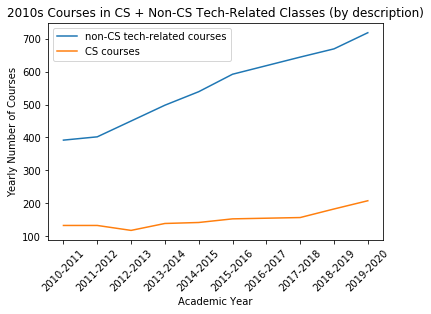

In [62]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) & (year_enrollment_df['subject'] != 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_cs = year_enrollment_df.loc[(year_enrollment_df['subject'] == 'CS')]
df_cs = df_cs.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

plt.plot(df_tech.index, df_tech['count'], label='non-CS tech-related courses')

plt.plot(df_cs.index, df_cs['count'], label='CS courses')

plt.ylabel('Yearly Number of Courses')
plt.xlabel('Academic Year')
plt.title('2010s Courses in CS + Non-CS Tech-Related Classes (by description)')
plt.legend()
plt.xticks(rotation=45)
plt.plot()

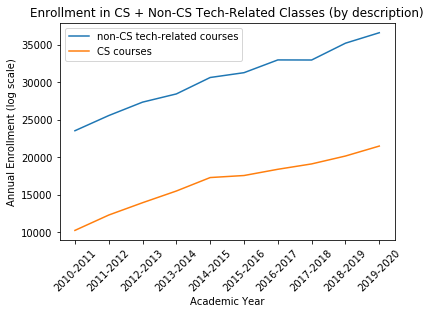

In [63]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) | (year_enrollment_df['subject'] == 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_cs = year_enrollment_df.loc[(year_enrollment_df['subject'] == 'CS')]
df_cs = df_cs.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(df_tech.index, df_tech['enrollment'], label='non-CS tech-related courses')

ax.plot(df_cs.index, df_cs['enrollment'], label='CS courses')

ax.set_ylabel('Annual Enrollment (log scale)')
ax.set_xlabel('Academic Year')
ax.set_title('Enrollment in CS + Non-CS Tech-Related Classes (by description)')
ax.legend()
ax.set_xticklabels(df_tech.index, rotation=45)
fig.savefig('cs_non-cs-tech_enrollment.png', format='png')

In [64]:
df_tech

enrollment  count
year                        
2010-2011       23550    525
2011-2012       25572    535
2012-2013       27361    568
2013-2014       28457    637
2014-2015       30646    681
2015-2016       31288    745
2016-2017       32988    773
2017-2018       32977    801
2018-2019       35219    852
2019-2020       36614    926

In [65]:
df_cs

enrollment  count
year                        
2010-2011       10265    133
2011-2012       12312    133
2012-2013       13955    118
2013-2014       15516    139
2014-2015       17309    142
2015-2016       17580    153
2016-2017       18411    155
2017-2018       19127    157
2018-2019       20179    183
2019-2020       21506    208

[]

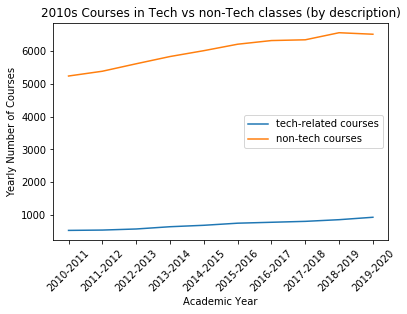

In [66]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) | (year_enrollment_df['subject'] == 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_not_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] == 0) & (year_enrollment_df['subject'] != 'CS')]
df_not_tech = df_not_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

plt.plot(df_tech.index, df_tech['count'], label='tech-related courses')

plt.plot(df_not_tech.index, df_not_tech['count'], label='non-tech courses')

plt.ylabel('Yearly Number of Courses')
plt.xlabel('Academic Year')
plt.title('2010s Courses in Tech vs non-Tech classes (by description)')
plt.legend()
plt.xticks(rotation=45)
plt.plot()

<Figure size 432x288 with 0 Axes>

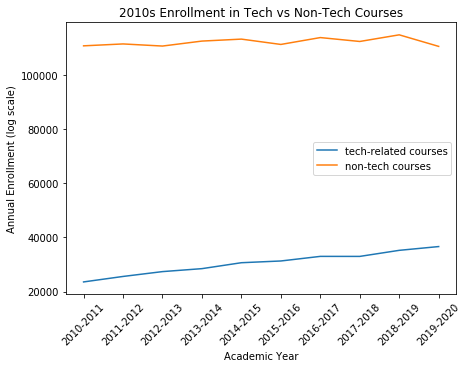

In [90]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) | (year_enrollment_df['subject'] == 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_not_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] == 0) & (year_enrollment_df['subject'] != 'CS')]
df_not_tech = df_not_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

plt.tight_layout()
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(df_tech.index, df_tech['enrollment'], label='tech-related courses')

ax.plot(df_not_tech.index, df_not_tech['enrollment'], label='non-tech courses')

ax.set_ylabel('Annual Enrollment (log scale)')
ax.set_xlabel('Academic Year')
ax.set_title('2010s Enrollment in Tech vs Non-Tech Courses')
ax.legend()
ax.set_xticklabels(df_tech.index, rotation=45)
fig.savefig('tech_non-tech_enrollment.png', format='png')

In [91]:
df_tech

enrollment  count
year                        
2010-2011       23550    525
2011-2012       25572    535
2012-2013       27361    568
2013-2014       28457    637
2014-2015       30646    681
2015-2016       31288    745
2016-2017       32988    773
2017-2018       32977    801
2018-2019       35219    852
2019-2020       36614    926

In [93]:
df_not_tech

enrollment  count
year                        
2010-2011      110770   5239
2011-2012      111471   5385
2012-2013      110689   5613
2013-2014      112527   5834
2014-2015      113253   6013
2015-2016      111285   6210
2016-2017      113821   6322
2017-2018      112382   6345
2018-2019      114834   6561
2019-2020      110566   6515

### Enrollment in tech + ethics classes (by description)

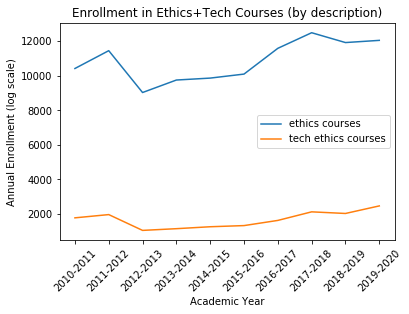

In [68]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) | (year_enrollment_df['subject'] == 'CS')]
#df_tech.to_csv('df_tech.csv')

df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_ethics = year_enrollment_df.loc[(year_enrollment_df['ethics_description'] > 0)]
#df_ethics.to_csv('df_ethics.csv')

df_ethics = df_ethics.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})


df_tech_ethics = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) & (year_enrollment_df['ethics_description'] > 0)]
#df_tech_ethics.to_csv('df_tech_ethics.csv')

df_tech_ethics = df_tech_ethics.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

fig, ax = plt.subplots(figsize=(6, 4))
#ax.plot(df_tech.index, df_tech['enrollment'], label='tech-related courses')
ax.plot(df_ethics.index, df_ethics['enrollment'], label='ethics courses')
ax.plot(df_tech_ethics.index, df_tech_ethics['enrollment'], label='tech ethics courses')

ax.set_ylabel('Annual Enrollment (log scale)')
ax.set_xlabel('Academic Year')
ax.set_title('Enrollment in Ethics+Tech Courses (by description)')
ax.legend(loc='center right')
ax.set_xticklabels(df_tech.index, rotation=45)

fig.savefig('tech_ethics_enrollment_descript.png', format='png')

In [79]:
df_tech_ethics

enrollment  count
year                        
2010-2011        1775     35
2011-2012        1963     39
2012-2013        1049     32
2013-2014        1148     36
2014-2015        1260     63
2015-2016        1327     58
2016-2017        1626     67
2017-2018        2122     82
2018-2019        2028     89
2019-2020        2465    103

In [69]:
df_ethics = year_enrollment_df.loc[(year_enrollment_df['ethics_description'] > 0)]
df_ethics = df_ethics.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

In [70]:
df_ethics

enrollment  count
year                        
2010-2011       10412    429
2011-2012       11443    456
2012-2013        9023    499
2013-2014        9745    518
2014-2015        9857    602
2015-2016       10089    617
2016-2017       11579    659
2017-2018       12481    733
2018-2019       11912    724
2019-2020       12039    746

In [71]:
cs_tech_ethics = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0)\
                                        &(year_enrollment_df['subject'] == 'CS')\
                                       &(year_enrollment_df['ethics_description'] > 0)]
cs_tech_ethics = cs_tech_ethics.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})
cs_tech_ethics

enrollment  count
year                        
2010-2011          63      1
2014-2015         212      2
2015-2016         499      6
2016-2017         971      4
2017-2018        1137      4
2018-2019         857      5
2019-2020         947      9

In [83]:
# a look into departments
df_tech_ethics = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) & (year_enrollment_df['ethics_description'] > 0)]
df_tech_ethics = df_tech_ethics.groupby(['year','subject']).agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'}).reset_index()
df_tech_ethics
#df_tech_ethics.to_csv('department_analysis.csv')

year   subject  enrollment  count
0    2010-2011   ARTHIST          27      2
1    2010-2011   CHEMENG          52      1
2    2010-2011  CLASSART          42      2
3    2010-2011  CLASSHIS          29      1
4    2010-2011      COMM          16      2
..         ...       ...         ...    ...
283  2019-2020       SOC          23      2
284  2019-2020       STS          34      3
285  2019-2020      SURG          10      1
286  2019-2020      TAPS           6      1
287  2019-2020     THINK         102      1

[288 rows x 4 columns]

In [86]:
yearly = df_tech_ethics.loc[df_tech_ethics['year'] == '2019-2020']
yearly.sort_values(by='enrollment', ascending=False).reset_index()
# yearly.to_csv('1011.csv')

index       year   subject  enrollment  count
0     262  2019-2020        CS         947      9
1     274  2019-2020       LAW         330     15
2     259  2019-2020       CME         169      2
3     279  2019-2020   POLISCI         128      3
4     265  2019-2020      EDUC         111      5
5     287  2019-2020     THINK         102      1
6     255  2019-2020       CEE          84      5
7     280  2019-2020      PSYC          72      2
8     281  2019-2020   PUBLPOL          59      6
9     260  2019-2020      COMM          42      4
10    270  2019-2020   HISTORY          41      8
11    271  2019-2020   INTLPOL          38      3
12    278  2019-2020      PHIL          38      4
13    268  2019-2020    FEMGEN          37      1
14    258  2019-2020  CLASSICS          34      1
15    284  2019-2020       STS          34      3
16    283  2019-2020       SOC          23      2
17    267  2019-2020  ETHICSOC          23      3
18    254  2019-2020   ARCHLGY          21      1
19    282  2019-2020       PWR          18      1
20    257  2019-2020  CHINLANG          14      3
21    266  2019-2020   ENGLISH          13      1
22    269  2019-2020  FILMSTUD          12      1
23    272  2019-2020  INTNLREL          11      1
24    285  2019-2020      SURG          10      1
25    256  2019-2020      CHEM           9      1
26    275  2019-2020  LINGUIST           8      1
27    261  2019-2020   COMPMED           8      1
28    251  2019-2020  AFRICAAM           8      2
29    252  2019-2020    AMSTUD           7      1
30    286  2019-2020      TAPS           6      1
31    263  2019-2020      CSRE           4      2
32    273  2019-2020  JEWISHST           2      1
33    276  2019-2020       MED           2      2
34    277  2019-2020      NBIO           0      2
35    264  2019-2020     EARTH           0      1
36    253  2019-2020    ANTHRO           0      2

[Text(0, 0, '2010-2011'),
 Text(0, 0, '2011-2012'),
 Text(0, 0, '2012-2013'),
 Text(0, 0, '2013-2014'),
 Text(0, 0, '2014-2015'),
 Text(0, 0, '2015-2016'),
 Text(0, 0, '2016-2017'),
 Text(0, 0, '2017-2018'),
 Text(0, 0, '2018-2019'),
 Text(0, 0, '2019-2020')]

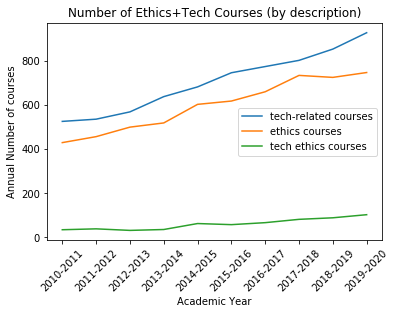

In [80]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) | (year_enrollment_df['subject'] == 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_ethics = year_enrollment_df.loc[(year_enrollment_df['ethics_description'] > 0)]
df_ethics = df_ethics.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_tech_ethics = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) & (year_enrollment_df['ethics_description'] > 0)]
df_tech_ethics = df_tech_ethics.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(df_tech.index, df_tech['count'], label='tech-related courses')
ax.plot(df_ethics.index, df_ethics['count'], label='ethics courses')
ax.plot(df_tech_ethics.index, df_tech_ethics['count'], label='tech ethics courses')

ax.set_ylabel('Annual Number of courses')
ax.set_xlabel('Academic Year')
ax.set_title('Number of Ethics+Tech Courses (by description)')
ax.legend(loc='center right')
ax.set_xticklabels(df_tech.index, rotation=45)

In [81]:
df_tech_ethics

enrollment  count
year                        
2010-2011        1775     35
2011-2012        1963     39
2012-2013        1049     32
2013-2014        1148     36
2014-2015        1260     63
2015-2016        1327     58
2016-2017        1626     67
2017-2018        2122     82
2018-2019        2028     89
2019-2020        2465    103

In [75]:
df_tech.head()

enrollment  count
year                        
2010-2011       23550    525
2011-2012       25572    535
2012-2013       27361    568
2013-2014       28457    637
2014-2015       30646    681

In [76]:
df_ethics.head()

enrollment  count
year                        
2010-2011       10412    429
2011-2012       11443    456
2012-2013        9023    499
2013-2014        9745    518
2014-2015        9857    602

In [77]:
df_tech_ethics.head()

enrollment  count
year                        
2010-2011        1775     35
2011-2012        1963     39
2012-2013        1049     32
2013-2014        1148     36
2014-2015        1260     63

### Enrollment in CS 181 + 182

[]

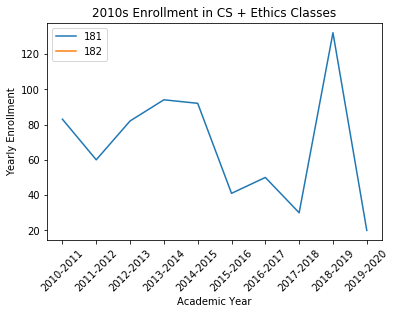

In [78]:
codes = ['181', '182']

for code in codes:
    code_df = year_enrollment_df.loc[(year_enrollment_df['code'] == code) & (year_enrollment_df['subject'] == 'CS')]
    plt.plot(code_df['year'], code_df['enrollment'], label=code)

plt.ylabel('Yearly Enrollment')
plt.xlabel('Academic Year')
plt.title('2010s Enrollment in CS + Ethics Classes')
plt.legend()
plt.xticks(rotation=45)
plt.plot()